In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Community detection/')#更改路径，''里面为更改的路径
from tensorflow.keras.optimizers import Adam # - Works

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Community detection/')
import nocd


import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize



%matplotlib inline

torch.set_default_tensor_type(torch.cuda.FloatTensor)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
from scipy import sparse
import math


__all__ = [
    'BerpoDecoder',
]


class BernoulliDecoder(nn.Module):
    def __init__(self, num_nodes, num_edges, balance_loss=False):
        """Base class for Bernoulli decoder.

        Args:
            num_nodes: Number of nodes in a graph.
            num_edges: Number of edges in a graph.
            balance_loss: Whether to balance contribution from edges and non-edges.
        """
        super().__init__()
        self.num_nodes = num_nodes
        self.num_edges = num_edges
        self.num_possible_edges = num_nodes**2 - num_nodes
        self.num_nonedges = self.num_possible_edges - self.num_edges
        self.balance_loss = balance_loss

    def forward_batch(self, emb, idx):
        """Compute probabilities of given edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)
            idx: edge indices, shape (batch_size, 2)

        Returns:
            edge_probs: Bernoulli distribution for given edges, shape (batch_size)
        """
        raise NotImplementedError

    def forward_full(self, emb):
        """Compute probabilities for all edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)

        Returns:
            edge_probs: Bernoulli distribution for all edges, shape (num_nodes, num_nodes)
        """
        raise NotImplementedError

    def loss_batch(self, emb, ones_idx, zeros_idx):
        """Compute loss for given edges and non-edges."""
        raise NotImplementedError

    def loss_full(self, emb, adj):
        """Compute loss for all edges and non-edges."""
        raise NotImplementedError


class BerpoDecoder(BernoulliDecoder):
    def __init__(self, num_nodes, num_edges, balance_loss=False):
        super().__init__(num_nodes, num_edges, balance_loss)
        edge_proba = num_edges / (num_nodes**2 - num_nodes)
        self.eps = -np.log(1 - edge_proba)

    def forward_batch(self, emb, idx):
        """Compute probabilities of given edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)
            idx: edge indices, shape (batch_size, 2)

        Returns:
            edge_probs: Bernoulli distribution for given edges, shape (batch_size)
        """
        e1, e2 = idx.t()
        logits = torch.sum(emb[e1] * emb[e2], dim=1)
        logits += self.eps
        probs = 1 - torch.exp(-logits)
        return td.Bernoulli(probs=probs)

    def forward_full(self, emb):
        """Compute probabilities for all edges.

        Args:
            emb: embedding matrix, shape (num_nodes, emb_dim)

        Returns:
            edge_probs: Bernoulli distribution for all edges, shape (num_nodes, num_nodes)
        """
        logits = emb @ emb.t()
        logits += self.eps
        probs = 1 - torch.exp(-logits)
        return td.Bernoulli(probs=probs)

    def loss_batch(self, emb, ones_idx, zeros_idx):
        """Compute BerPo loss for a batch of edges and non-edges."""
        print('loss_batch')

        # Loss for edges
        e1, e2 = ones_idx[:, 0], ones_idx[:, 1]
        edge_dots = torch.sum(emb[e1] * emb[e2], dim=1)
        loss_edges = -torch.mean(torch.log(-torch.expm1(-self.eps - edge_dots)))

        # Loss for non-edges
        ne1, ne2 = zeros_idx[:, 0], zeros_idx[:, 1]
        loss_nonedges = torch.mean(torch.sum(emb[ne1] * emb[ne2], dim=1))
        if self.balance_loss:
            neg_scale = 1.0
        else:
            neg_scale = self.num_nonedges / self.num_edges
        return (loss_edges + neg_scale * loss_nonedges) / (1 + neg_scale)

    def loss_full(self, emb, adj):
        """Compute BerPo loss for all edges & non-edges in a graph."""
        print('loss_old')
        e1, e2 = adj.nonzero()
        edge_dots = torch.sum(emb[e1] * emb[e2], dim=1)
        loss_edges = -torch.sum(torch.log(-torch.expm1(-self.eps - edge_dots)))

        # Correct for overcounting F_u * F_v for edges and nodes with themselves
        self_dots_sum = torch.sum(emb * emb)
        correction = self_dots_sum + torch.sum(edge_dots)
        sum_emb = torch.sum(emb, dim=0, keepdim=True).t()
        loss_nonedges = torch.sum(emb @ sum_emb) - correction

        if self.balance_loss:
            neg_scale = 1.0
        else:
            neg_scale = self.num_nonedges / self.num_edges
        return (loss_edges / self.num_edges + neg_scale * loss_nonedges / self.num_nonedges) / (1 + neg_scale)

    def loss_full_new(self, emb, adj):
        """Compute BerPo loss for all edges & non-edges in a graph."""
        #print(adj.shape)
        
        #emb: 2085*10. 代表了2085个节点，每个节点10个维度的属性
        #adj: 2085*2085.代表了邻接矩阵。
       # print('loss_full_new')
        
        #emb=torch.tensor(normalize(emb))  
        
        #emb=normalize(emb)

        #e1, e2 = adj.nonzero() # e1:15982*1. adj的第几行非0； e2: 15982*1.adj的第几列非0
        e1, e2=adj.coalesce().indices()
       # adj_nonzero=[]
      #  for i in range(0,len(e1)):
         #   adj_nonzero.append(adj[e1[i],e2[i]])
            
        # 这个计算很快
        edge_dots = torch.sum(emb[e1] * emb[e2], dim=1)

        #edge_dots_ny=edge_dots.cpu().detach().numpy()
        

        #loss=sum(abs(normalized_edge-normalized_adj))/len(e1) 
        adj_list=torch.tensor(adj.coalesce().values().tolist())

        adj_list_log=torch.log(adj_list) 
 
        #loss=sum(abs(edge_dots-adj_list_log))/len(e1)
        
        
        Lossfunction = nn.L1Loss()
        
        #Lossfunction = nn.MSELoss()
       # adj_nonzero_t = torch.FloatTensor(adj_nonzero)
        loss=Lossfunction(edge_dots,adj_list_log)
        
        return loss

In [ ]:
hidden_sizes = [128]    # hidden sizes of the GNN
     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
max_epochs = 5000        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)



In [ ]:
os.getcwd()


'/content/drive/My Drive/Community detection'

In [ ]:
import torch
torch.cuda.device_count()

1

In [ ]:
from scipy import sparse

###### work
#A = sparse.load_npz('A_work.npz')
#X=sparse.load_npz('X_node2vec_work.npz')


#####weekend

A = sparse.load_npz('A_weekend.npz')
X=sparse.load_npz('X_node2vec_weekend.npz')


x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()


N=X.shape[0]
K=10

sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).cuda()
adj_norm = gnn.normalize_adj(A)
#decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
decoder = BerpoDecoder(N, A.nnz, balance_loss=balance_loss)




/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
A_coo=A.tocoo()
A_tensor = torch.sparse_coo_tensor(torch.LongTensor([A_coo.row, A_coo.col]), 
                                   torch.FloatTensor(A_coo.data),
                                   torch.Size(A_coo.shape)).cuda()

<ipython-input-10-0c41cf5168a5>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  A_tensor = torch.sparse_coo_tensor(torch.LongTensor([A_coo.row, A_coo.col]),


In [ ]:
#decoder = nocd.nn.BerpoDecoderNEW(N, A.nnz, balance_loss=balance_loss)
max_epochs = 10000        # number of epochs to train

#weight_decay = 1e-5
weight_decay = 1e-6

lr = 0.0003             # learning rate
# 0.0001
opt = torch.optim.Adam(gnn.parameters(), lr=lr)


val_loss = np.inf
loss=np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=100)
model_saver = nocd.train.ModelSaver(gnn)


for epoch, batch in enumerate(sampler):
   # print(epoch)
    if epoch > max_epochs:
        break
    if epoch % 100 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(x_norm, adj_norm))
          #  val_loss = decoder.loss_full(Z, A)
            val_loss = decoder.loss_full_new(Z, A_tensor)
           # val_loss = decoder.loss_full(Z, A)

          #  print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.2f}')
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}')
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
   # if stochastic_loss:
   #     loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
  #  else:
    loss = decoder.loss_full_new(Z,A_tensor)
    
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    
    loss.backward()
    opt.step()

Epoch    0, loss.full = 1.3501
Epoch  100, loss.full = 0.7594
Epoch  200, loss.full = 0.7122
Epoch  300, loss.full = 0.7083
Epoch  400, loss.full = 0.7093
Epoch  500, loss.full = 0.7098
Epoch  600, loss.full = 0.7086
Epoch  700, loss.full = 0.7073
Epoch  800, loss.full = 0.7080
Epoch  900, loss.full = 0.7061
Epoch 1000, loss.full = 0.7045
Epoch 1100, loss.full = 0.7041
Epoch 1200, loss.full = 0.7043
Epoch 1300, loss.full = 0.7022
Epoch 1400, loss.full = 0.7016
Epoch 1500, loss.full = 0.7007
Epoch 1600, loss.full = 0.6988
Epoch 1700, loss.full = 0.6975
Epoch 1800, loss.full = 0.6973
Epoch 1900, loss.full = 0.6961
Epoch 2000, loss.full = 0.6955
Epoch 2100, loss.full = 0.6960
Epoch 2200, loss.full = 0.6950
Epoch 2300, loss.full = 0.6955
Epoch 2400, loss.full = 0.6942
Epoch 2500, loss.full = 0.6951
Epoch 2600, loss.full = 0.6933
Epoch 2700, loss.full = 0.6953
Epoch 2800, loss.full = 0.6936
Epoch 2900, loss.full = 0.6931
Epoch 3000, loss.full = 0.6915
Epoch 3100, loss.full = 0.6924
Epoch 32

In [ ]:
A

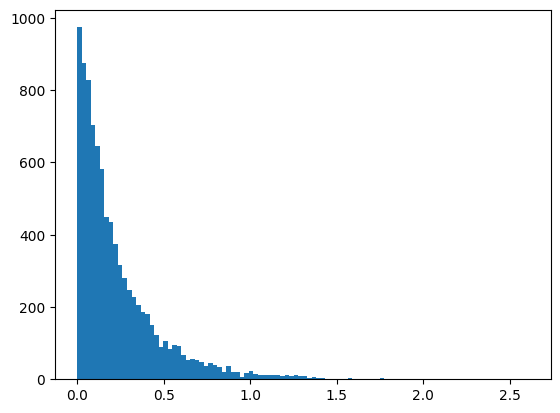

In [ ]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

In [ ]:
thresh = 0.5

Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
#print(f'Final nmi = {get_nmi(thresh):.3f}')

In [ ]:
Z_pred

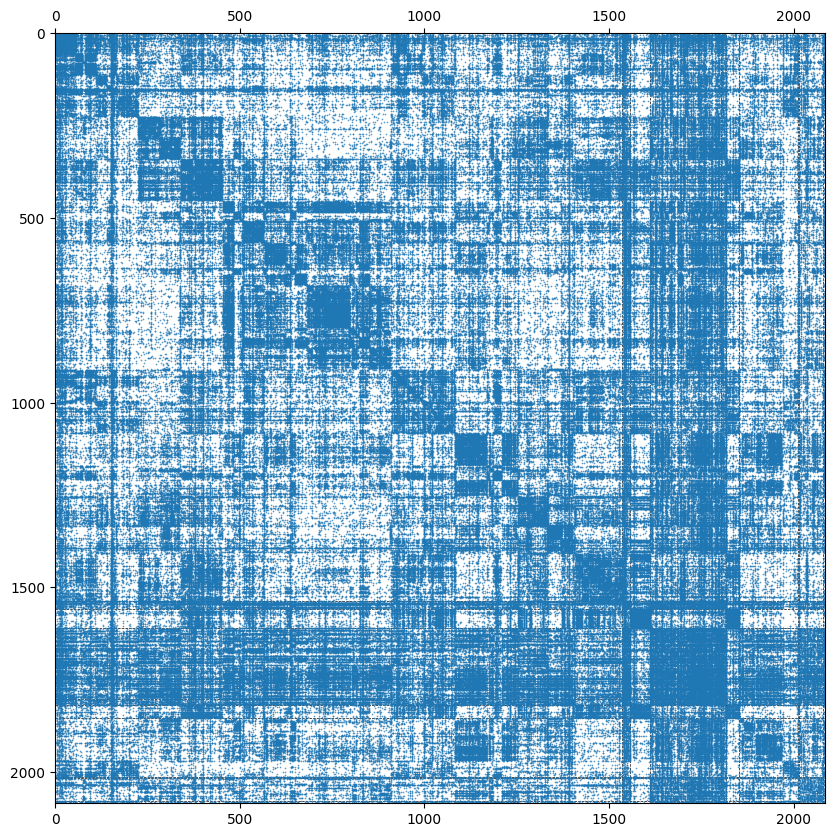

In [ ]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.2)

In [ ]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.0938
 - conductance = 0.8412
 - density     = 4.428e-01
 - clust_coef  = 2.145e+04


In [ ]:
np.savetxt('Z_weekend_0331.csv',Z_pred)
np.savetxt('Z_weekend_zmatrix_0331.csv',Z.cpu().detach().numpy())


In [ ]:
from google.colab import files
files.download('Z_weekend_0331.csv')

In [ ]:
files.download('Z_work_zmatrix_0331.csv')




In [ ]:
from google.colab import drive
import shutil

drive.mount('/content/drive')

folder_path = 'D://'

file_path='Z_work_0317.csv'
shutil.copy(file_path, folder_path)


In [ ]:
A_tensor.coalesce().values().tolist()

In [ ]:
e1, e2=A_tensor.coalesce().indices()


In [ ]:
e1, e2=adj_norm.coalesce().indices()
       # adj_nonzero=[]
      #  for i in range(0,len(e1)):
         #   adj_nonzero.append(adj[e1[i],e2[i]])
            
        # 这个计算很快
edge_dots = torch.sum(Z[e1] * Z[e2], dim=1)

        #edge_dots_ny=edge_dots.cpu().detach().numpy()
        

adj_list=torch.tensor(adj_norm.coalesce().values().tolist())
loss=sum(abs(edge_dots-adj_list))/len(e1)

In [ ]:
len(e1)

In [ ]:
A

In [ ]:
len(adj_nonzero)

In [ ]:
torch.nonzero(A_tensor)

In [ ]:
A_tensor.dim()

In [ ]:
A_tensor

In [ ]:
adj_nonzero=[]
for i in range(0,1000):
    adj_nonzero.append(A_tensor[1000,1000])
            

In [ ]:


indices = A_tensor._indices()
values = A_tensor._values()
coords = indices.t().tolist()


In [ ]:
A_tensor

In [ ]:
A.nonzero()